# THE WAR AGAINST HEART ARRHYTHMIA

In [2]:
import numpy as np
from scipy.optimize import fsolve
import math
import pywt
import time
import cython
import pandas as pd
import scipy.signal
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy import interpolate
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from statsmodels.tsa.stattools import acf
import random
from collections import deque
import statsmodels.graphics.tsaplots as st
from scipy import special
from scipy.signal import find_peaks
import sklearn
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy import integrate
import pyspeckit
from pyspeckit import moments
import arch
from arch.unitroot import VarianceRatio
import pyspark
import jupyterthemes
from jupyterthemes import jtplot

In [3]:
# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Signal preprocessing:

1. Subtract the mean
2. Five order moving average filtering
3. High Pass Filtering with f = 1 Hz (Drift Suppression)
4. low-pass Butterworth filtering with fc = 30 Hz

In [4]:
def signal_creator(MIT_signal_whole):
    MIT_data = []
    for i in range(len(MIT_signal_whole[0])):
        MIT_data.append(MIT_signal_whole[0][i][0])
    MIT_data = np.array(MIT_data)
    nulls = np.isnan(MIT_data)
    l=[]
    for i in range(len(nulls)):
        if nulls[i] == True:
            MIT_data[i] = 0
            l.append(i) 
    MIT_data[l] = np.mean(MIT_data)
    #plt.plot(MIT_data)
    #plt.xlim(0,600)
    return MIT_data


def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l) 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def starting_point(signal,t,fs):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

def signal_preprocessor(data,time,uu,mm):
    mean = np.mean(data)
    data = data - mean
    
    data = moving_average(data,5)
    #plt.plot(time,data)
    #plt.xlim(0,10)
    data = np.array(data)
    
    data = butter_highpass_filter(data, 1, uu, 5)
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,data)
    
    MIT_signal = butter_lowpass_filter(data, 1, mm, 5)
    fs=30
    time = np.arange(MIT_signal.size)/fs
    time = time/10
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,MIT_signal)

    return MIT_signal,time

def ready_signal(directory,freq1):
    s = wfdb.io.rdsamp(directory)
    s = signal_creator(s)
    t = np.arange(s.size)/freq1
    s = wfdb.processing.normalize_bound(s, lb=-1, ub=1)
    s,t= signal_preprocessor(s,t,freq1,30)
    return s,t

def starting_point_end(signal,t):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = t[index_M[0][0]:-1]
    return signal_start,time_M

def for_TCI(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(ss[i][j])
            time.append(tt[i][j])
    return values,time

def start_end_ext(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            x,y = starting_point_end(ss[i][j],tt[i][j])
            values.append(x)
            time.append(y)
    return values,time

## Signals and Times arrays:

In [5]:
signals = []
times = []
str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]
for i in MIT_str:
    x,y = ready_signal(str1+i,360)
    signals.append(x)
    times.append(y)

In [6]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]
for i in cudb_str:
    x,y = ready_signal(str2+i,250)
    signals.append(x)
    times.append(y)

In [7]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]
for i in vfdb_str:
    x,y = ready_signal(str3+i,250)
    signals.append(x)
    times.append(y)

In [8]:
def for_sigmar(s,t):
    sigs = []
    tims = []
    for i in s:
        x = np.array_split(i,int(len(i)/3300))
        sigs.append(x)
    for i in t:
        y = np.array_split(i,int(len(i)/3300))
        tims.append(y)
    return sigs,tims

In [9]:
ss,tt = for_sigmar(signals,times)

In [10]:
sm,tm = start_end_ext(ss,tt)

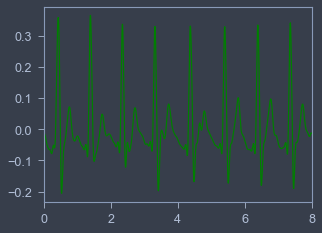

In [11]:
plt.xlim((0, 8))
#plt.ylim((930,1050))
plt.plot(tt[2][0][0:2400],ss[2][0][0:2400],color="green")

In [12]:
for i in range(0,105):
    for j in range(len(ss[i])):
        if len(ss[i][j])!=len(tt[i][j]):
            print("oops")    ##Checking if time and signal are the same size, and they are!

In [13]:
def annotation_symbols(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.aux_note)
    return np.array(ann_list)

def annotation_locations(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.sample)
    return np.array(ann_list)

In [14]:
ann_list =[]
ann_locations = []

str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]

for i in MIT_str:
    ann_list.append(annotation_symbols(str1,i))
    ann_locations.append(annotation_locations(str1,i))

In [15]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]

for i in cudb_str:
    ann_list.append(annotation_symbols(str2,i))
    ann_locations.append(annotation_locations(str2,i))

In [16]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]

for i in vfdb_str:
    ann_list.append(annotation_symbols(str3,i))
    ann_locations.append(annotation_locations(str3,i))

In [17]:
ann_list=np.array(ann_list)
ann_locations = np.array(ann_locations)

In [18]:
wfdb.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [19]:
wfdb.io.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed qrs detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


In [20]:
def fib_location_1(lis,loc):
    listlist = []
    listmist = []
    for i in range(len(lis)):
        for j in range(len(lis[i])):
            if lis[i][j] == '(SVTA' or lis[i][j] == '(VT':
                for k in range(len(ann_list[i][j+1:-1])):
                    if ann_list[i][j+k+1] != '':
                        lastone = loc[i][j+k]
                        duration = lastone - loc[i][j-1]
                        break
                if i <=47:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Duration: ",duration/300,"s"," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", ((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])),"until: ",((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append(((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append(((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                elif 47 < i < 83: 
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                elif i >= 83:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
    return np.array(listlist),np.array(listmist)

In [21]:
def fib_location_2(lis,loc):
    listlist = []
    listmist = []
    for i in range(len(lis)):
        for j in range(len(lis[i])):
            if lis[i][j]== '(VF' or lis[i][j] == '(VFL':
                for k in range(len(ann_list[i][j+1:-1])):
                    if ann_list[i][j+k+1] != '':
                        lastone = loc[i][j+k]
                        duration = lastone - loc[i][j-1]
                        break
                if i <=47:
                    listlist.append(((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append(((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                elif 47 < i < 83:
                    listlist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                elif i >= 83:
                    listlist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
    return np.array(listlist),np.array(listmist)

In [22]:
VT_labels = [0.0]*14236
VT_labels = np.array(VT_labels)
Y_loc= fib_location_1(ann_list,ann_locations)

Signal number:  7  Type:  (VT  Location:  63624  Duration:  1.7866666666666666 s  Location in Signal division =  19  Location in vertical labels =  1195 until:  1195
Signal number:  14  Type:  (SVTA  Location:  251900  Duration:  5.233333333333333 s  Location in Signal division =  75  Location in vertical labels =  2623 until:  2624
Signal number:  24  Type:  (VT  Location:  39210  Duration:  2.2066666666666666 s  Location in Signal division =  11  Location in vertical labels =  4519 until:  4519
Signal number:  24  Type:  (VT  Location:  226766  Duration:  1.7166666666666666 s  Location in Signal division =  68  Location in vertical labels =  4576 until:  4576
Signal number:  24  Type:  (VT  Location:  340338  Duration:  3.0 s  Location in Signal division =  102  Location in vertical labels =  4610 until:  4610
Signal number:  24  Type:  (VT  Location:  385419  Duration:  1.9133333333333333 s  Location in Signal division =  116  Location in vertical labels =  4624 until:  4624
Signal 

Signal number:  99  Type:  (VT  Location:  395461  Location in Signal division =  119  Location in vertical labels =  13167 until:  13167
Signal number:  99  Type:  (VT  Location:  462134  Location in Signal division =  139  Location in vertical labels =  13187 until:  13187
Signal number:  99  Type:  (SVTA  Location:  465134  Location in Signal division =  140  Location in vertical labels =  13188 until:  13188
Signal number:  99  Type:  (VT  Location:  471519  Location in Signal division =  142  Location in vertical labels =  13190 until:  13190
Signal number:  99  Type:  (SVTA  Location:  473673  Location in Signal division =  143  Location in vertical labels =  13191 until:  13191
Signal number:  100  Type:  (VT  Location:  291506  Location in Signal division =  88  Location in vertical labels =  13295 until:  13295
Signal number:  101  Type:  (VT  Location:  459865  Location in Signal division =  139  Location in vertical labels =  13505 until:  13505
Signal number:  102  Type:  (

In [23]:
i = 0
counter = 0
while 3 > 2:
    for l in range(Y_loc[0][i],Y_loc[1][i]+1):
        VT_labels[l] = 1.0
        counter+=1
    i+=1
    if i == 191:
        break

In [24]:
VT_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
VF_labels = [0.0]*14236
VF_labels = np.array(VF_labels)
Y_loc= fib_location_2(ann_list,ann_locations)

In [26]:
i = 0
counter = 0
while 3 > 2:
    for l in range(Y_loc[0][i],Y_loc[1][i]+1):
        VF_labels[l] = 1.0
        counter+=1
    i+=1
    if i == 115:
        break

In [27]:
VF_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
lismis1 = []
for i in range(len(VT_labels)):
    if VT_labels[i] == 1: 
        lismis1.append(i)

In [29]:
len(lismis1)

189

In [30]:
lismis2 = []
for i in range(len(VF_labels)):
    if VF_labels[i] == 1: 
        lismis2.append(i)

In [31]:
len(lismis2)

97

In [32]:
osmosis = []
for i in range(len(VF_labels)):
    if VF_labels[i] == 0 and VT_labels[i]==0: 
        osmosis.append(i)

In [33]:
len(osmosis)

13952

In [34]:
VT = pd.DataFrame(VT_labels)
VT.columns = ["VT"]
VF = pd.DataFrame(VF_labels)
VF.columns = ["VF"]

In [35]:
#VF.to_csv("./Parameter_Data/VF.csv",sep=',')
#VT.to_csv("./Parameter_Data/VT.csv",sep=',')

# Time parameter

In [161]:
t_cst = len(ss[0][0])/tt[0][0][-1]
t_cst  ##number of signal points in 1 second

300.09047044632086

## Parameter 1: TCI

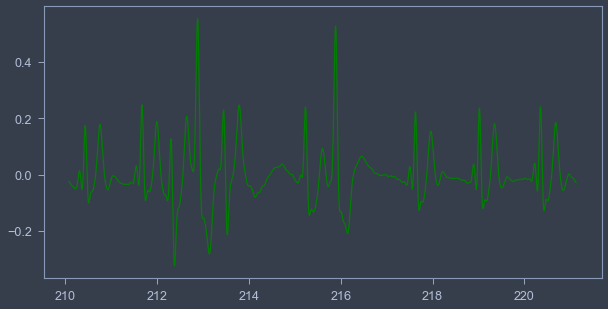

In [39]:
ss[6][19].size
tt[6][19].size
plt.figure(figsize=(10,5))
plt.plot(tt[6][19],ss[6][19],color = "green")

In [40]:
def binary_td(signal,m,n):
    threshold = np.arange(n-m).astype("float")
    k = m
    s = m
    z = 0
    binary_list = []
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(signal[int(np.ceil(m*300)):int(np.ceil((m+1)*300))])
        i+=1
        m+=1
    for l in threshold:
        p = 0
        for j in signal[int(np.ceil(k*300)):int(np.ceil((k+1)*300))]:
            if j < l :
                binary_list.append(0)
            else: 
                binary_list.append(1)
        k+=1
    return np.array(binary_list),threshold

array([0, 0, 0, ..., 0, 0, 0])

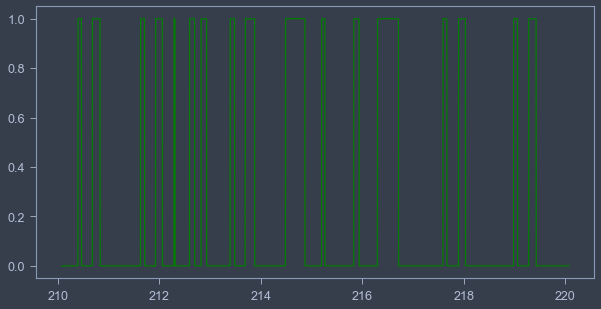

In [43]:
binlist,thd = binary_td(ss[6][19],0,10)
plt.figure(figsize=(10,5))
plt.plot(tt[6][19][0:10*300],binlist,color = "green")
binlist[300:2700]

In [45]:
def TCI(binlist,thd,m,n):
    pulses = [0]*(n-m+2)
    q = 0
    p = 300
    ## pulse calculation:
    k=0
    for i in range(len(thd)):
        bin2 = binlist[q:p]
        for i in range(len(bin2)-1):
            if bin2[i]!=bin2[i+1]:
                pulses[k]+=1
        pulses[k] = pulses[k]/2
        k+=1
        q+=300
        p+=300
    q = 0
    p=900
    k=0
    t1_idx = 0
    t2_idx = 0
    t3_idx = 0
    t4_idx = 0
    TCI=[]
    for l in range(len(thd)-2):
        countidx1 = 0
        countidx2 = 0
        countidx3 = 0
        countidx4 = 0
        bin2 = binlist[q:p]
        
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx1+=1
                if countidx1/2 == pulses[k]:
                    t1_idx = f+q
                    break
        h1 = q+300
        bin2=binlist[h1:p]
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t2_idx = h1+f+1
                break
                    
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx3 +=1
                if countidx3/2 == pulses[k+1]:
                    t3_idx = f+h1
                    break
        h2 = q+600            
        bin2 =binlist[h2:p]             
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t4_idx = f+1+h2
                break
        t1 = (h1-t1_idx)/300
        t2 = (t2_idx-h1)/300
        t3 = (h2 - t3_idx)/300
        t4 = (t4_idx-h2)/300
        
        if t1+t2 == 0:
            TCI.append(0)
        elif t3+t4==0:
            TCI.append(0)
        else:
            form1 = (pulses[k+1]-1)+(t2/(t1+t2))+(t3/(t3+t4))
            if form1 == 0:
                TCI.append(0)
            else:
                form2=1000/form1
                TCI.append(form2)
            q+=300
            p+=300
            k+=1
    return np.array(TCI)

In [46]:
sr,tr = for_TCI(ss,tt)

In [47]:
binlist,thd = binary_td(sr[14040],1,9)
TCI(binlist,thd,2,8)

array([216.60049857, 252.52242152, 236.70197538, 257.97063104,
       227.52344181, 255.05350773])

## TCI Tests:

#### With VF-VT :

In [38]:
counter = 0
for i in lismis1:
    binlist,thd = binary_td(sr[i],1,9)
    x = TCI(binlist,thd,2,8)
    count2 = 0
    for i in x:
        if i < 400:
            count2 +=1
    if count2 > 2:
        counter+=1

In [39]:
counter

136

In [40]:
counter/len(lismis1)

0.48056537102473496

In [49]:
counter = 0
for i in lismis2:
    binlist,thd = binary_td(sr[i],1,9)
    x = TCI(binlist,thd,2,8)
    count2 = 0
    for i in x:
        if i < 400:
            count2 +=1
    if count2 > 2:
        counter+=1

In [50]:
counter

61

In [51]:
counter/len(lismis2)

0.6288659793814433

#### Without VF-VT :

In [52]:
counter = 0
for i in osmosis:
    binlist,thd = binary_td(sr[i],1,9)
    x = TCI(binlist,thd,2,8)
    count2 = 0
    for i in x:
        if i < 400:
            count2 +=1
    if count2 <= 2:
        counter+=1

In [53]:
counter

9421

In [54]:
counter/len(osmosis)

0.6752436926605505

## TCI Extraction:

In [44]:
def TCI_ext(ss):
    values = []
    for i in range(len(ss)):
        binlist,thd = binary_td(ss[i],1,9)
        values.append(TCI(binlist,thd,2,8))
    return np.array(values)

In [45]:
TCI_array = TCI_ext(sr)

In [46]:
TCI_array[14040] ## Sample VF

array([216.60049857, 252.52242152, 236.70197538, 257.97063104,
       227.52344181, 255.05350773])

In [47]:
l1,l2,l3,l4,l5,l6 = [],[],[],[],[],[]
for i in TCI_array:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])
    l4.append(i[3])
    l5.append(i[4])
    l6.append(i[5])
    
l1 = pd.DataFrame(l1)
l2 = pd.DataFrame(l2)
l3 = pd.DataFrame(l3)
l4 = pd.DataFrame(l4)
l5 = pd.DataFrame(l5)
l6 = pd.DataFrame(l6)

ll = []
ll.append(l1)
ll.append(l2)
ll.append(l3)
ll.append(l4)
ll.append(l5)
ll.append(l6)

TCI_DF = pd.concat(ll,axis=1)
TCI_DF.columns = ["TCI_1","TCI_2","TCI_3","TCI_4","TCI_5","TCI_6"]

In [55]:
#TCI_DF

In [49]:
#TCI_DF.to_csv("TCI.csv",sep=',')

# Parameter 2: ACF Algorithm

In [73]:
qrs_inds = processing.xqrs_detect(sig=sm[14040][0:2400], fs=41)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


14

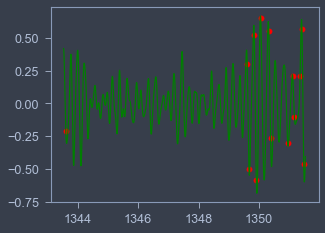

In [74]:
plt.plot(tm[14040][0:2400],sm[14040][0:2400],color="green")
plt.scatter(tm[14040][qrs_inds],sm[14040][qrs_inds],color="red")
x = int(len(qrs_inds))
x

In [75]:
ser = acf(ss[2][0][0:2400],nlags=x,alpha=0.01)

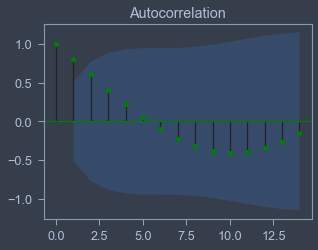

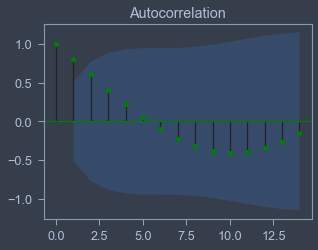

In [76]:
st.plot_acf(ser[0],color="green")

In [77]:
vr = VarianceRatio(ser[0])
vr.overlap=False
vr.stat

2.558789314777398

In [78]:
def ACF_test(signal):
    qrs_inds = processing.xqrs_detect(sig=signal, fs=41)
    x = int(len(qrs_inds))
    ser = acf(signal,nlags=int(x*3),alpha=0.95)
    q = []
    for i in range(len(ser[1])):
        q.append(ser[1][i][1])
    q=np.array(q)
    vr = VarianceRatio(q)
    vr.overlap=False
    return vr.stat

In [79]:
ACF_test(sm[0][0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.



The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



7.339132504130635

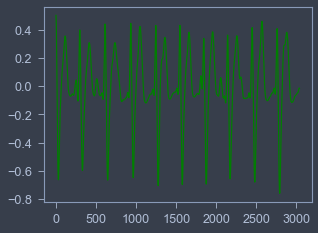

In [80]:
plt.plot(sm[196*7],color="green")

## ACF Test:

In [81]:
%%capture
counter=0
for i in lismis1:
    if ACF_test(sm[i][0:2400]) <= 6.61:
        counter+=1

In [82]:
counter

59

In [83]:
counter/len(lismis1)

0.31216931216931215

In [84]:
%%capture
counter=0
for i in lismis2:
    if ACF_test(sm[i][0:2400]) <= 6.61:
        counter+=1

In [85]:
counter

22

In [86]:
counter/len(lismis2)

0.2268041237113402

In [87]:
%%capture
counter=0
for i in osmosis:
    if ACF_test(sm[i][0:2400]) >= 6.61:
        counter+=1

In [88]:
counter

6923

In [89]:
counter/len(osmosis)

0.4962012614678899

## ACF Extraction:

In [53]:
def ACF_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(ACF_test(ss[i][0:2400]))
        print(i)
    return np.array(values)

In [54]:
%%capture
ACF = ACF_ext(sm)

In [90]:
#ACF

In [56]:
ACF_DF = pd.DataFrame(ACF)
ACF_DF.columns = ["ACF"]

In [91]:
#ACF_DF

In [92]:
#ACF_DF.to_csv("ACF.csv",sep=',')

## Parameter 3: VF Filter

In [93]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def VF_Filter_leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [94]:
VF_Filter_leakage(ss[2][0][0:2400],int(get_points(ss[2][0][0:2400],300)),200,500)

0.6344872267021999

## VF Filter Test:

#### For VF-VT:

In [95]:
counter = 0
for i in lismis1:
    if  VF_Filter_leakage(sm[i][0:2400],int(get_points(sm[i][0:2400],300)),200,500) < 0.625:
        counter+=1
        
counter

50

In [96]:
counter/len(lismis1)

0.26455026455026454

In [97]:
counter = 0
for i in lismis2:
    if  VF_Filter_leakage(sm[i][0:2400],int(get_points(sm[i][0:2400],300)),200,500) < 0.625:
        counter+=1
        
counter

72

In [98]:
counter/len(lismis2)

0.7422680412371134

#### Without VF-VT:

In [99]:
counter = 0
for i in osmosis:
    if  VF_Filter_leakage(sm[i][0:2400],int(get_points(sm[i][0:2400],300)),200,500) >= 0.625:
        counter+=1
        
counter

11366

In [100]:
counter/len(osmosis)

0.8146502293577982

## VF Filter Extraction

In [65]:
def VFF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(VF_Filter_leakage(ss[i][j][0:2400],int(get_points(ss[i][j][0:2400],300)),200,500))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["VFF"]
    return v

In [66]:
VFF_DF = VFF_ext(ss)

In [67]:
#VFF_DF.to_csv("./Parameter_Data/VFF.csv",sep=',')

## Parameter 4: Spectral Algorithm

In [140]:
Ham = sm[14040][0:2400]*np.hamming(2400)

(0, 2400)

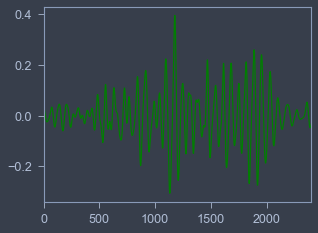

In [141]:
plt.plot(Ham,color="green")
plt.xlim(0,2400)

In [142]:
fourier = scipy.fft(Ham)

In [143]:
fourier

array([-0.25205581+0.j        , -0.25195559+0.03270575j,
       -0.25168673+0.0657917j , ..., -0.2511819 -0.09902773j,
       -0.25168673-0.0657917j , -0.25195559-0.03270575j])

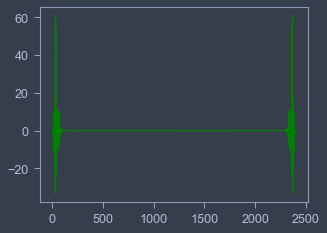

In [144]:
plt.plot(fourier,color="green")

In [145]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [146]:
fourier_2 = fourier_abs(fourier).real

In [147]:
fourier_2

array([0.25205581, 0.28466134, 0.31747842, ..., 0.35020963, 0.31747842,
       0.28466134])

(0, 2400)

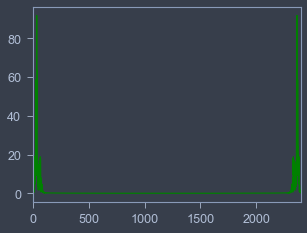

In [148]:
plt.plot(fourier_2,color="green")
plt.xlim(0,2400)

In [149]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

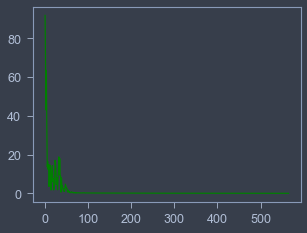

In [150]:
plt.plot(fourier_3,color="green")

In [151]:
time_2

2.0

In [152]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m)+range1)
print(m)

34
91.85441736088006


In [153]:
time_max_amp = (f.index(m)+34)/300 ## in seconds
if time_max_amp != 0:
    God_of_War = 1/time_max_amp
else:
    God_of_War = 0
God_of_War

8.823529411764707

In [154]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [155]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([0., 0., 0., ..., 0., 0., 0.])

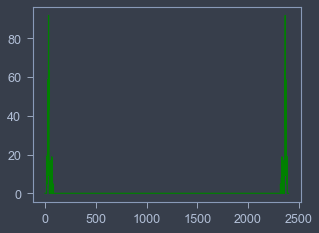

In [156]:
plt.plot(fourier_final,color = "green")

In [157]:
def SPEC(signal):
    Ham = signal*np.hamming(2400)
    fourier = scipy.fft(Ham)
    fourier_2 = fourier_abs(fourier).real
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int((time_1*300))
    range2 = int((time_2*300))

    fourier_3 = fourier_2[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = (f.index(m)+range1)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    fourier_final = amp_maxsetter(fourier_2,m)
        
    A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),fourier_final)
    A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),fourier_final)
    A3 = A3_calc(fourier_final,God_of_War)
    
    return A1,A2,A3

In [158]:
def A_calc(f1,f2,f3,f4,signal):
    i1 = int((1/f1)*300)
    i2 = int((1/f2)*300)
    i3 = int((1/f3)*300)
    i4 = int((1/f4)*300)

    if i1<i2:
        A = sum(signal[i1:i2])
    else:
        A = sum(signal[i2:i1])
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])
    return (A/B)

In [159]:
def A3_calc(signal,God_of_War):
    A = np.arange(2*God_of_War,8*God_of_War,0.6)
    A = ((1/A)*t_cst).astype(int)
    A = np.unique(A)
    A = sum(signal[A])
    
    i3 = int((1/0.5)*300)
    i4 = int((1/np.minimum(20*God_of_War,100))*300)
    
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])
    return A/B

In [162]:
SPEC(sm[14040][0:2400])

(0.046171280190558446, 0.6919794659233124, 0.0396922751917916)

## SPEC TESTS:

#### With VF-VT:

In [142]:
counter1,counter2,counter3,counter4 = 0,0,0,0
for i in lismis1:
    x = SPEC(sm[i][0:2400])
    if x[0] < 0.19:
        counter1+=1
    if x[1] >=0.45:
        counter2+=1
    if x[2] <= 0.09:
        counter3+=1
    if x[0] < 0.19 and  x[1] >=0.45 and x[2] <= 0.09 :
        counter4+=1

In [143]:
counter1/len(lismis1)

0.9365079365079365

In [144]:
counter2/len(lismis1)

0.15343915343915343

In [145]:
counter3/len(lismis1)

0.08465608465608465

In [146]:
counter4/len(lismis1)

0.026455026455026454

In [147]:
counter1,counter2,counter3,counter4 = 0,0,0,0
for i in lismis2:
    x = SPEC(sm[i][0:2400])
    if x[0] < 0.19:
        counter1+=1
    if x[1] >=0.45:
        counter2+=1
    if x[2] <= 0.09:
        counter3+=1
    if x[0] < 0.19 and  x[1] >=0.45 and x[2] <= 0.09 :
        counter4+=1

In [148]:
counter1/len(lismis2)

1.0

In [149]:
counter2/len(lismis2)

0.2268041237113402

In [150]:
counter3/len(lismis2)

0.08247422680412371

In [151]:
counter4/len(lismis2)

0.061855670103092786

#### Without VF-VT:

In [152]:
counter1,counter2,counter3,counter4 = 0,0,0,0
for i in osmosis:
    x = SPEC(sm[i][0:2400])
    if x[0] < 0.19:
        counter1+=1
    if x[1] >=0.45:
        counter2+=1
    if x[2] <= 0.09:
        counter3+=1
    if x[0] < 0.19 and  x[1] >=0.45 and x[2] <= 0.09 :
        counter4+=1

In [153]:
1 - (counter1/len(osmosis))

0.016556766055045857

In [154]:
1 - (counter2/len(osmosis))

0.7380303899082569

In [155]:
1 - (counter3/len(osmosis))

0.9709719036697247

In [156]:
1 - (counter4/len(osmosis))

0.9777809633027523

## Spectral Extraction:

In [157]:
def SPEC_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(SPEC(ss[i][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SPEC_1","SPEC_2","SPEC_3"]
    return v

In [158]:
SPEC_DF = SPEC_ext(sm)

In [159]:
#SPEC_DF

In [160]:
#SPEC_DF.to_csv("./Parameter_Data/SPEC.csv",sep=',')

## Parameter 5: Complexity Measure Algorithm

In [161]:
nurgle = ss[2][0][0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

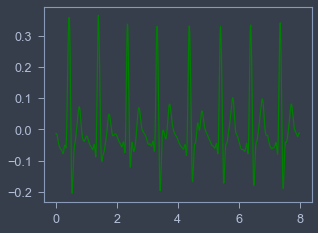

In [162]:
plt.plot(tt[2][0][0:2400],nurgle,color="green")

In [163]:
def Td(nurgle):
    meanbean = np.mean(nurgle)
    nurgle = nurgle - meanbean
    Vp = np.amax(nurgle)
    Vn = np.amin(nurgle)
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>=nc:
        T = 0.2*Vn
    return T

In [164]:
Threshold = Td(nurgle)
Threshold

0

In [165]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [166]:
binary = binary_comp(Threshold,nurgle)
binary

array([0, 0, 0, ..., 0, 0, 0])

In [167]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary,length):
    cn = 1
    S = binary[0].astype("str")
    Q = binary[1].astype("str")
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C= con
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) >= len(binary)-1:
                cn+=1
                break
            Q = binary[len(S)].astype("str")
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+binary[len(S)+m].astype("str")
                m+=1
            else:
                break
    bn = length/(math.log2(length))
    
    return cn/bn

In [168]:
def complexity_measure(nurgle,length):
    Threshold = Td(nurgle)
    binary = binary_comp(Threshold,nurgle)
    return complexity(binary,length)

In [169]:
def comp_measure(signal,length):
    l = []
    k = 0
    j = 1000
    for i in range(0,3):
        l .append(complexity_measure(signal[k:j],length))
        k+=1000
        j+=1000
    return np.array(l)

In [170]:
comp_measure(sm[14040],1000) ## use an AWS for this

array([0.1893499 , 0.1893499 , 0.16941833])

## Complexity measure tests:

In [172]:
counter=0
for i in lismis1: 
    x = comp_measure(sm[i],1000)
    for i in x:
        if i >= 0.15:
            counter+=1
            break

In [174]:
counter/len(lismis1)

0.4973544973544973

In [176]:
counter=0
for i in lismis2: 
    x = comp_measure(sm[i],1000)
    for i in x:
        if i >= 0.15:
            counter+=1
            break

In [177]:
counter/len(lismis2)

0.38144329896907214

In [178]:
counter=0
for i in osmosis: 
    x = comp_measure(sm[i],1000)
    for i in x:
        if i >= 0.15:
            counter+=1
            break

In [179]:
1 - (counter/len(osmosis))

0.6725200688073394

## Complexity Measure Extraction:

In [180]:
def Comp_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(comp_measure(ss[i],1000))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Complexity_1","Complexity_2","Complexity_3"]
    return v

In [207]:
Comp_DF = Comp_ext(sm)

In [208]:
#Comp_DF.to_csv("./Parameter_Data/Complexity.csv",sep=',')

## Parameter 6: Standard Exponential Algorithm

In [36]:
def std_exp_algthm(t,s,Tau):
    M = np.amax(s)
    tmax = (np.where(s==M))[0]/300 +t[0]
    exp_part = np.exp((-1*np.absolute(t-tmax))/Tau)
    curve = M*exp_part
    
    #plt.figure(figsize=(20,10))
    #plt.plot(t,s)
    #plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(s-curve))).flatten()
    #plt.plot(t[idx],s[idx],'ro')
    
    Time_length = len(s)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

172.5

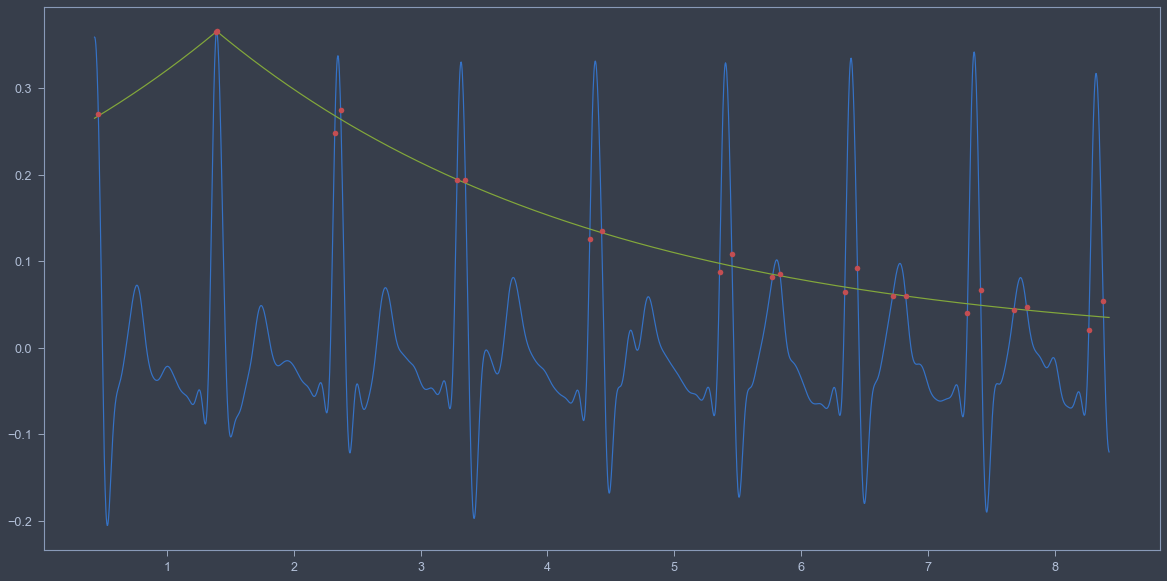

In [78]:
std_exp_algthm(tm[196*2][0:2400],sm[196*2][0:2400],3)

## Standard Exponential Tests:

#### For VFVT :

In [37]:
counter = 0
for i in lismis1:
    if std_exp_algthm(tm[i][0:2400],sm[i][0:2400],3) >= 180:
        counter+=1
counter

89

In [38]:
counter/len(lismis1)

0.4708994708994709

In [40]:
counter = 0
for i in lismis2:
    if std_exp_algthm(tm[i][0:2400],sm[i][0:2400],3) >= 180:
        counter+=1
counter

70

In [42]:
counter/len(lismis2)

0.7216494845360825

#### Without VFVT :

In [43]:
counter = 0
for i in osmosis:
    if std_exp_algthm(tm[i][0:2400],sm[i][0:2400],3) <= 180:
        counter+=1
counter

8609

In [44]:
counter/len(osmosis)

0.6170441513761468

## Standard Exponential Extraction:

In [110]:
def stdexp_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(std_exp_algthm(tt[i][0:2400],ss[i][0:2400],3))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["ST_EXP"]
    return v

In [111]:
ST_EXP_DF = stdexp_ext(sm,tm) 

In [45]:
#ST_EXP_DF

In [46]:
#ST_EXP_DF.to_csv("./Parameter_Data/Standard_exp.csv",sep=',')

## Parameter 7: Modified Exponential Algorithm

In [50]:
def MEA(t,ss,Tau):
    real_curve = [0.0]*len(t)
    index_M  = argrelextrema(ss,np.greater)
    idx_M = index_M[0]
    gladiator = np.amax(ss)
    idx_M2 = []
    for i in idx_M:
        if ss[i]>0.2*gladiator:
            idx_M2.append(i)
    idx_M2 = np.array(idx_M2)
    idx_M1 = []
    for i in idx_M:
        if ss[i]>0.1*gladiator:
            idx_M1.append(i)
    idx_M1 = np.array(idx_M1)
    
    ## draw the first curve
    pt = 0
    qqq = 0
    lifts=0
    while 2 < 3: 
        if pt >= idx_M[-1]: 
            break
        M1 = ss[pt]
        tm1 = t[pt]
        curve_1 = M1*np.exp(-1*(t-tm1)/(Tau))
        idx_1 = np.argwhere(np.diff(np.sign(ss-curve_1))).flatten()
        for i in idx_1:
            if i > 11+pt:
                idx_work = i
                break
        ## find all the maxes 
        for j in range(len(idx_M)):
            if idx_work <= idx_M[j]:
                idx_M_work = idx_M[j]
                break
        real_curve[pt:idx_work] = (curve_1[pt:idx_work])
        real_curve[idx_work:idx_M_work]=(ss[idx_work:idx_M_work])
        pt = idx_M_work
        if pt ==qqq:
            break
        qqq = idx_M_work
        lifts+=1
        if pt >= idx_M[-1]:     
            break
    idx_final = np.argwhere(np.diff(np.sign(ss-real_curve))).flatten()
    #plt.figure(figsize=(20,10))
    #plt.plot(t,ss,color="blue")
    #plt.plot(t,real_curve,color="green")
    #plt.plot(t[idx_final],ss[idx_final],'ro')
    pt=idx_M_work
    Time_length = t[-1]-t[0]
    form = lifts/Time_length
    return form*60

187.5781575656523

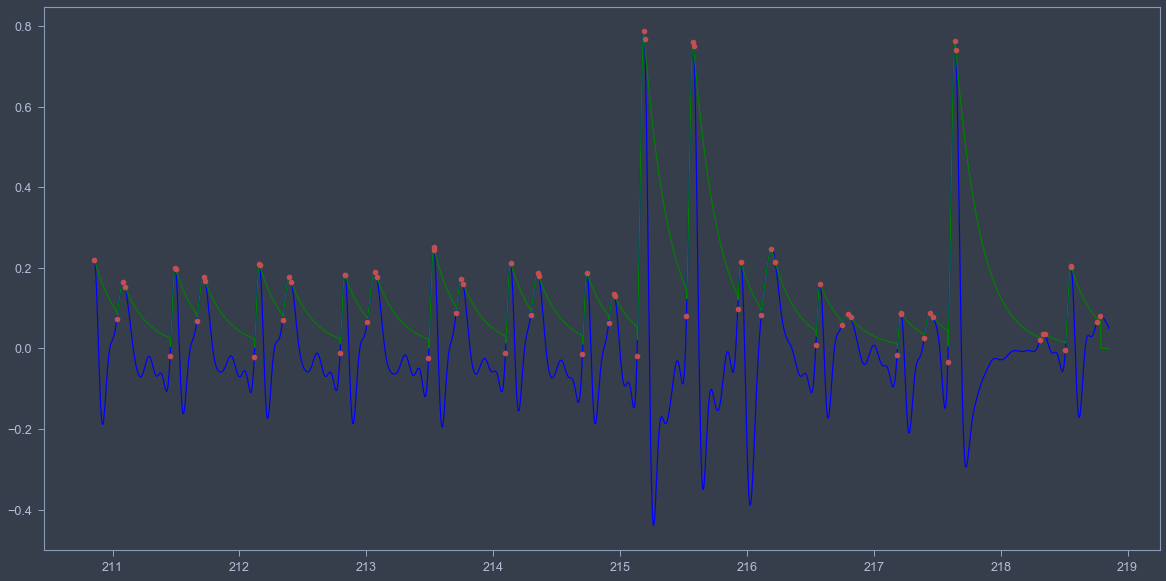

In [49]:
MEA(tm[6879][0:2400],sm[6879][0:2400],0.2)

## MEA Tests:

In [51]:
counter = 0 
for i in lismis1:
    if MEA(tm[i][0:2400],sm[i][0:2400],0.2) >= 180:
        counter+=1

In [52]:
counter

65

In [53]:
counter/len(lismis1)

0.3439153439153439

In [54]:
counter = 0 
for i in lismis2:
    if MEA(tm[i][0:2400],sm[i][0:2400],0.2) >= 180:
        counter+=1

In [55]:
counter

38

In [56]:
counter/len(lismis2)

0.3917525773195876

In [57]:
counter = 0 
for i in osmosis:
    if MEA(tm[i][0:2400],sm[i][0:2400],0.2) <= 180:
        counter+=1
counter

9599

In [58]:
counter

9599

In [59]:
counter/len(osmosis)

0.6880017201834863

## Modified Exponential Extraction:

In [116]:
def MEA_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(MEA(tt[i][0:-1],ss[i][0:-1],0.2))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["MDF_EXP"]
    return v

In [117]:
MEA_DF = MEA_ext(sm,tm)

In [60]:
#MEA_DF

In [61]:
#MEA_DF.to_csv("./Parameter_Data/MEA.csv",sep=',')

## Parameter 8: Signal Comparison

In [62]:
signal = sm[196*2][0:2400]
signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
time_1 = tm[196*2][0:2400]
qrs_inds = processing.xqrs_detect(sig=signal, fs=150)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


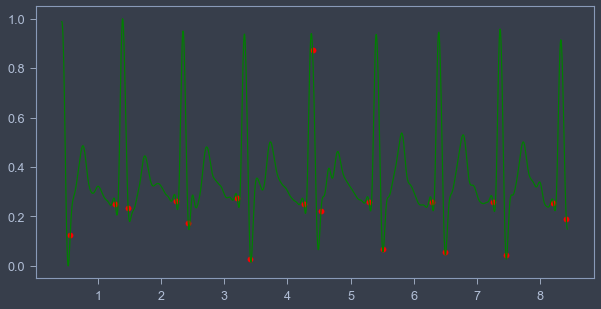

In [68]:
plt.figure(figsize=(10,5))
plt.plot(time_1,signal,color="green")
plt.scatter(time_1[qrs_inds],signal[qrs_inds],color="red")

Let's create the first signal:

In [69]:
MIT_signal_1 = sm[196*2]
time_1 = tm[196*2]

Adjust the peaks to match the QRS points found for the signal we want to examine:

In [70]:
SCA_1 = MIT_signal_1[0:2400]
qrs_inds_2 = processing.xqrs_detect(sig=SCA_1, fs=55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


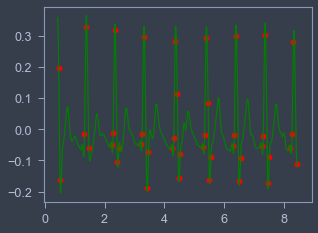

In [74]:
plt.plot(time_1[0:2400],SCA_1,color="green")
plt.scatter(time_1[qrs_inds_2],SCA_1[qrs_inds_2],color = "red")

Now to create the second signal:

In [76]:
avg = [sm[196][0:2400],sm[196*3][0:2400],sm[196*5][0:2400],sm[196*6][0:2400],sm[196*8][0:2400],sm[196*9][0:2400],sm[196*10][0:2400],sm[196*11][0:2400],
       sm[196*12][0:2400],sm[196*13][0:2400],sm[196*14][0:2400],sm[196*15][0:2400],sm[196*16][0:2400],sm[196*17][0:2400],sm[196*18][0:2400],sm[196*19][0:2400]]
avg = np.array(avg)

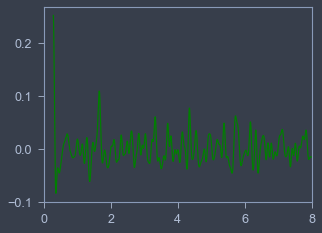

In [77]:
SCA_2 = sum(avg)/len(avg)
plt.xlim(0,8)
plt.plot(tm[196][0:2400],SCA_2,color="green")

In [78]:
SCA_2 = sm[196*3]

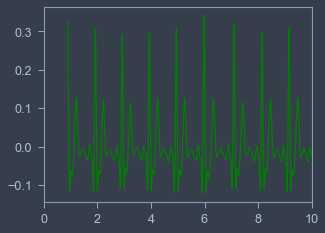

In [80]:
plt.xlim(0,10)
plt.plot(tm[196*3],SCA_2,color="green")

Now for the third signal, it just has an elevated T wave:

In [83]:
SCA_3 = sm[196*7]
time_third = tm[196*7]

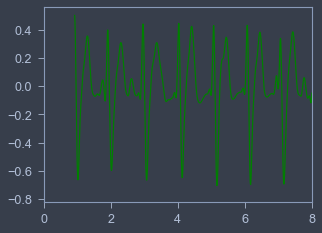

In [84]:
plt.xlim(0,8)
plt.plot(time_third,SCA_3,color="green")

For the fourth signal:

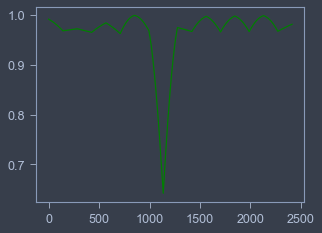

In [86]:
x = []
spacing1 = len(signal)/(len(qrs_inds)-1)
for i in range(len(signal[qrs_inds])-1):
    spacing2 = (signal[qrs_inds[i+1]] - signal[qrs_inds[i]])/spacing1
    y = np.arange(signal[qrs_inds[i]],signal[qrs_inds[i+1]],spacing2) ##Needs to be a formula
    for i in y:
        x.append(i)
x = np.array(x)
SCA_4 = np.cos(x)
plt.plot(SCA_4,color="green")
len(SCA_4)
SCA_4 = np.resize(SCA_4,(2400,))

Now for the residual calculation

In [87]:
I0 = qrs_inds[0]
I1 = qrs_inds[-1]

In [88]:
def Integral_calc(S,F,I0,I1):
    y = np.absolute(S-F)
    R = integrate.simps(y[I0:I1])
    return R

In [89]:
RF   = Integral_calc(signal,SCA_4,I0,I1)
RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
print("RF = ",RF)
print("RFS1 = ",RFS1)
print("RFS2 = ",RFS2)
print("RFS3 = ",RFS3)

RF =  1420.0822122139732
RFS1 =  847.3116387568134
RFS2 =  861.4594570700103
RFS3 =  865.2519024075865


In [90]:
IF  = Integral_calc(SCA_4,0,I0,I1)
IE  = Integral_calc(signal,0,I0,I1)
IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)

print("IF = ",IF)
print("IE = ",IE)
print("IS1 = ",IS1)
print("IS2 = ",IS2)
print("IS3 = ",IS3)

IF =  2265.691941765153
IE =  849.0952920046838
IS1 =  158.4708218947237
IS2 =  121.76697329824547
IS3 =  399.7139029773136


In [91]:
VRF = (RF/min(IF,IE))
VRS1 = RFS1/min(IS1,IE)
VRS2 = RFS2/min(IS2,IE)
VRS3 = RFS3/min(IS3,IE)

print("VRF = ",VRF)
print("VRS1 = ",VRS1)
print("VRS2 = ",VRS2)
print("VRS3 = ",VRS3)

VRF =  1.6724650643877788
VRS1 =  5.34679904241113
VRS2 =  7.074656072464133
VRS3 =  2.1646780258646525


In [92]:
t1 = VRF/VRS1
t2 = VRF/VRS2
t3 = VRF/VRS3

print("t1 = ",t1)
print("t2 = ",t2)
print("t3 = ",t3)

t1 =  0.3127974421932984
t2 =  0.23640231373187473
t3 =  0.7726160862744169


In [93]:
x= [1,2,3]
np.array(x)

array([1, 2, 3])

In [94]:
def SCA(signal):
    
    signal = wfdb.processing.normalize_bound(signal, lb=-1, ub=1)
    qrs_inds = processing.xqrs_detect(sig=signal, fs=150)
    
    if len(qrs_inds)<2:
        qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
        if len(qrs_inds)<2:
            signal = signal[300:-1]
            qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
            if len(qrs_inds)<2:
                qrs_inds = processing.xqrs_detect(sig=signal, fs=150)
                if len(qrs_inds)<2:
                    signal = signal[600:-1]
                    qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
                    if len(qrs_inds)<2:
                        qrs_inds = processing.xqrs_detect(sig=signal, fs=150)
                
    I0 = qrs_inds[0]
    I1 = qrs_inds[-1]
    
    RF   = Integral_calc(signal[0:2400],SCA_4,I0,I1)
    RFS1 = Integral_calc(signal[0:2400],SCA_1[0:2400],I0,I1)
    RFS2 = Integral_calc(signal[0:2400],SCA_2[0:2400],I0,I1)
    RFS3 = Integral_calc(signal[0:2400],SCA_3[0:2400],I0,I1)
    IF  = Integral_calc(SCA_4,0,I0,I1)
    IE  = Integral_calc(signal[0:2400],0,I0,I1)
    IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
    IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
    IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)
    VRF = (RF/min(IF,IE))
    VRS1 = RFS1/min(IS1,IE)
    VRS2 = RFS2/min(IS2,IE)
    VRS3 = RFS3/min(IS3,IE)
    t1 = VRF/VRS1
    t2 = VRF/VRS2
    t3 = VRF/VRS3
    
    l = [t1,t2,t3]
    
    return np.array(l)

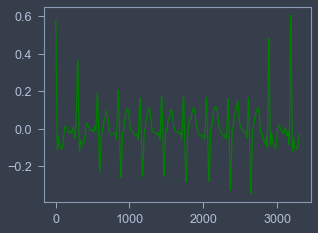

In [95]:
plt.plot(sm[861],color="green")

In [96]:
qrs_inds = processing.xqrs_detect(sig=sm[861], fs=150)
qrs_inds

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


array([  31,  302,  548,  597,  815,  857,  901, 1108, 1149, 1193, 1402,
       1444, 1486, 1699, 1741, 1785, 2011, 2054, 2096, 2305, 2370, 2401,
       2582, 2647, 2679, 2842, 2873, 2918, 3155, 3186, 3217])

In [97]:
SCA(sm[861])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


array([0.97599835, 0.73490105, 1.94458666])

## SCA TESTS:

In [98]:
%%capture
counter = 0
for i in lismis1:
    x = SCA(sm[i])
    k=0
    for j in x:
        if j<=1:
            k+=1
    if k == 3:
        counter+=1

In [99]:
counter

56

In [854]:
counter/len(lismis1)

0.4275618374558304

In [100]:
%%capture
counter = 0
for i in lismis2:
    x = SCA(sm[i])
    k=0
    for j in x:
        if j<=1:
            k+=1
    if k == 3:
        counter+=1

In [101]:
counter

42

In [102]:
counter/len(lismis2)

0.4329896907216495

In [103]:
%%capture
counter = 0
for i in osmosis:
    x = SCA(sm[i])
    print(i)
    for j in x:
        if j>=1:
            counter+=1
            break

In [104]:
counter

7978

In [105]:
counter/len(osmosis)

0.5718176605504587

## SCA Extraction: 

In [106]:
def SCA_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(SCA(ss[i]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA_1","SCA_2","SCA_3"]
    return v

In [149]:
%%capture
SCA_DF = SCA_ext(sm)

In [107]:
#SCA_DF

In [108]:
#SCA_DF.to_csv("./Parameter_Data/SCA.csv",sep=',')

# Parameter 9: Wavelet Based Algorithms

## Wavelet 1: Algorithm:

In [109]:
#pywt.wavelist()

(0, 2400)

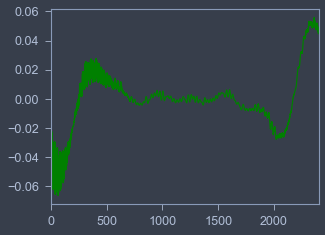

In [121]:
wavelet1 = pywt.cwt(sm[196][0:2400],200,"mexh")
plt.plot(wavelet1[0][0],color="green")
plt.xlim(0,2400)

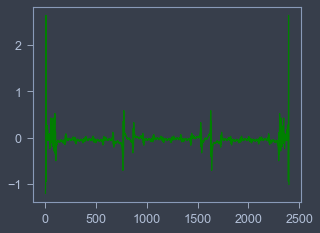

In [122]:
fourier1 = fft(wavelet1[0][0])
plt.plot(fourier1,color="green")

In [123]:
freq_cst = (1/(np.sqrt(2*np.pi)))

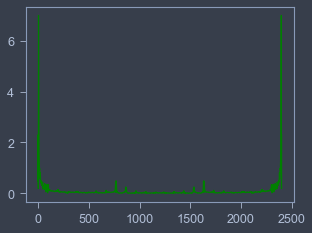

In [124]:
fourier1 = np.absolute(fourier1)
fourier1 = freq_cst*fourier1
plt.plot(fourier1,color="green")

(0, 10)

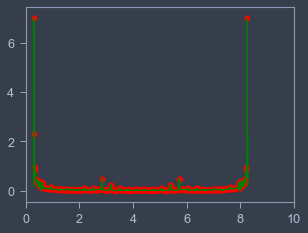

In [132]:
M = argrelextrema(fourier1,np.greater)[0]
plt.plot(tm[196][0:len(fourier1)],fourier1,color="green")
plt.scatter(tm[196][M],fourier1[M],color='red')
plt.xlim(0,10)

419

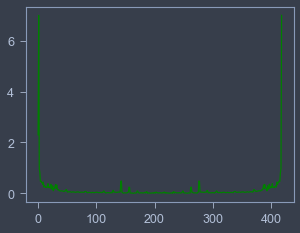

In [133]:
plt.plot(fourier1[M[0:2400]],color="green")
len(fourier1[M[0:2400]])

In [137]:
def SPEC2(signal):
    
    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int((time_1*300))
    range2 = int((time_2*300))

    ss = signal[range1:range2]
    
    m = np.amax(ss)
    f = ss.tolist()
    
    time_max_amp = (f.index(m)+range1)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
        
    A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),signal)
    A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),signal)
    A3 = A3_calc(signal,God_of_War)
    
    return A1,A2,A3

In [163]:
SPEC2(fourier1[M[0:2400]])

(0.0, 0.5811476370551072, 0.0100537053145895)

In [165]:
def wavelet_one(signal):
    wavelet1 = pywt.cwt(signal,200,"mexh")
    fourier1 = fft(wavelet1[0][0])
    freq_cst = (1/(np.sqrt(2*np.pi)))
    fourier1 = np.absolute(fourier1)
    fourier1 = freq_cst*fourier1
    M = argrelextrema(fourier1,np.greater)[0]
    
    return SPEC2(fourier1[M[0:2400]])

In [166]:
wavelet_one(sm[10][0:2400])

(0.0, 0.5860063625426831, 0.008800394297311684)

## Wavelet 1 Extraction:

In [169]:
def Wave1_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(wavelet_one(ss[i][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["WAVE_1","WAVE_2","WAVE_3"]
    return v

In [170]:
Wave1_DF = Wave1_ext(sm)

In [172]:
#Wave1_DF.to_csv("./Parameter_Data/Wave1.csv",sep=',')

## Wavelet 2 Algorithm:

Need to turn the SPEC algorithm into one big algorithm. This uses SPEC to check whether the signal is VF, if it is, then this second wavelet does not need to be considered. If it doesn't however, the following is performed:

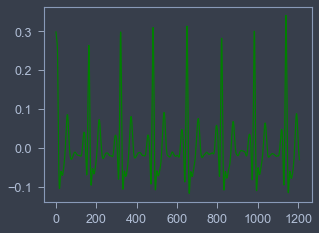

In [173]:
w = pywt.dwt(sm[196][0:2400],'db8','smooth')
plt.plot(w[0],color="green")

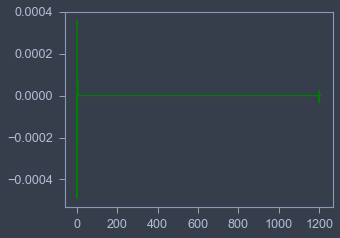

In [174]:
plt.plot(w[1],color="green")

In [175]:
qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=55)
len(qrs_wave2)/3

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


7.0

In [177]:
def Wave_2(signal):
    w = pywt.dwt(signal[0:2400],'db8','smooth')
    qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=41)
    return len(qrs_wave2)/3

In [178]:
%%capture
x = Wave_2(sm[14040][0:2400])

In [179]:
x

22.333333333333332

## Wavelet 2 Extraction:

In [193]:
def Wave2_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(Wave_2(sm[i][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["WAVE_2"]
    return v

In [171]:
%%capture
WAVE_2_DF = Wave2_ext(sm)

In [181]:
#WAVE_2_DF

In [182]:
#WAVE_2_DF.to_csv("./Parameter_Data/Wave2.csv",sep=',')

# Parameter 10: Li Algorithm

I used the continuous wavelet instead, as it allows for scaling:

In [194]:
def wavelet_finder(signal):
    signal = wfdb.processing.normalize_bound(signal, lb=-1, ub=1)
    w1 = pywt.cwt(signal,2,'mexh')
    #plt.plot(w1[0][0])
    
    w2 = pywt.cwt(signal,np.power(2,2),'mexh')
    #plt.figure()
    #plt.plot(w2[0][0])
    
    w3 = pywt.cwt(signal,np.power(2,3),'mexh')
    #plt.figure()
    #plt.plot(w3[0][0])
    
    w4 = pywt.cwt(signal,np.power(2,4),'mexh')
    #plt.figure()
    #plt.plot(w4[0][0])
    
    return w1[0][0],w2[0][0],w3[0][0],w4[0][0]

In [184]:
w1,w2,w3,w4 = wavelet_finder(sm[14040][0:2400])

In [185]:
w1,time1 = signal_preprocessor(w1,tm[14040],50,30)
w2,time2 = signal_preprocessor(w2,tm[14040],50,30)
w3,time3 = signal_preprocessor(w3,tm[14040],50,30)
w4,time4 = signal_preprocessor(w4,tm[14040],50,30)

In [186]:
def QRS_number_search(w1,w2,w3,w4,fs):
    qrs_w1 = processing.xqrs_detect(sig=w1, fs=50)
    qrs_w2 = processing.xqrs_detect(sig=w2, fs=50)
    qrs_w3 = processing.xqrs_detect(sig=w3, fs=50)
    qrs_w4 = processing.xqrs_detect(sig=w4, fs=50)
    
    return qrs_w1,qrs_w2,qrs_w3,qrs_w4

In [187]:
qrs1,qrs2,qrs3,qrs4 = QRS_number_search(w1,w2,w3,w4,50)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


33.333333333333336
35.0
36.0
38.333333333333336


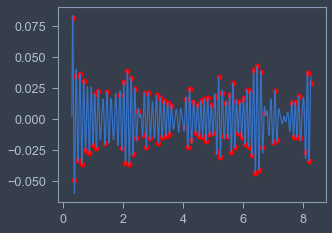

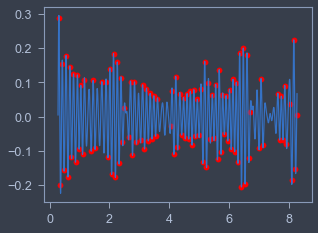

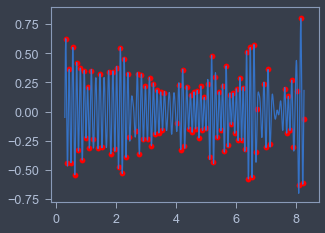

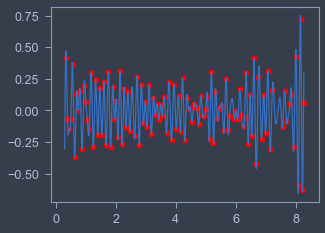

In [188]:
plt.plot(tm[196][0:2400],w1)
plt.scatter(tm[196][qrs1],w1[qrs1],color="red")
print(len(qrs1)/3)

plt.figure()

plt.plot(tm[196][0:2400],w2)
plt.scatter(tm[196][qrs2],w2[qrs2],color="red")
print(len(qrs2)/3)

plt.figure()

plt.plot(tm[196][0:2400],w3)
plt.scatter(tm[196][qrs3],w3[qrs3],color="red")
print(len(qrs3)/3)

plt.figure()

plt.plot(tm[196][0:2400],w4)
plt.scatter(tm[196][qrs4],w4[qrs4],color="red")
print(len(qrs4)/3)

0 or greater than 5 times the window length in seconds, so 40 in the 8 second interval case

In [195]:
def Li_Algthm(s,t):
    w1,w2,w3,w4 = wavelet_finder(s[0:2400])
    
    w1,time1 = signal_preprocessor(w1,t,50,30)
    w2,time2 = signal_preprocessor(w2,t,50,30)
    w3,time3 = signal_preprocessor(w3,t,50,30)
    w4,time4 = signal_preprocessor(w4,t,50,30)
    
    qrs1,qrs2,qrs3,qrs4 = QRS_number_search(w1,w2,w3,w4,50)
    
    array = [len(qrs1)/3,len(qrs2)/3,len(qrs3)/3,len(qrs4)/3]
    
    return np.array(array)
    

In [190]:
%%capture
start_time = time.time()
x = Li_Algthm(sm[14040],tm[14040])
y = time.time()-start_time

In [191]:
x

array([33.33333333, 35.        , 36.        , 38.33333333])

In [192]:
y

0.11369657516479492

## Li Algorithm Tests:

#### With VF-VT :

In [196]:
%%capture
counter=0
for i in lismis1:
    x = Li_Algthm(sm[i],tm[i])
    for j in x:
        if j >=30:
            counter+=1
            break

In [47]:
counter

136

In [48]:
counter/len(lismis1)

0.48056537102473496

In [199]:
%%capture
counter=0
for i in lismis2:
    x = Li_Algthm(sm[i],tm[i])
    for j in x:
        if j >=30:
            counter+=1
            break

In [200]:
counter

70

In [201]:
counter/len(lismis2)

0.7216494845360825

#### Without VF-VT:

In [202]:
%%capture
counter=0
for i in osmosis:
    x = Li_Algthm(sm[i],tm[i])
    for j in x:
        if j >=30:
            counter+=1
            break

In [203]:
counter

2768

In [204]:
1 - (counter/len(osmosis))

0.801605504587156

## Li Algorithm Extraction

In [186]:
def Li_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(Li_Algthm(ss[i],tt[i]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Li_1","Li_2","Li_3","Li_4"]
    return v

In [188]:
%%capture
Li_DF = Li_ext(sm,tm)

In [205]:
#Li_DF

In [206]:
#Li_DF.to_csv("./Parameter_Data/Li.csv",sep=',')

# Parameter 11: Tompkins Algorithm

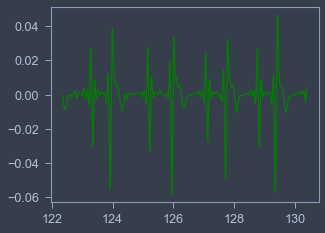

In [207]:
sig = np.gradient(sm[4519][0:2400],edge_order=1)
plt.plot(tm[4519][0:2400],sig,color="green")

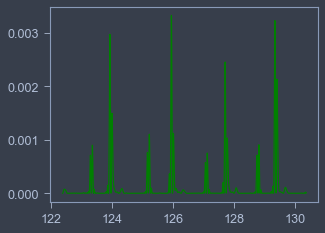

In [208]:
signal = np.power(sig,2)
plt.plot(tm[4519][0:2400],signal,color="green")

In [209]:
time2 = tm[4519][0:2400]
time2.shape

(2400,)

In [210]:
signal.shape

(2400,)

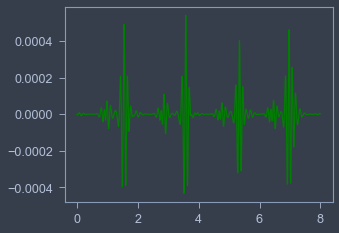

In [211]:
sigmig,time3 = signal_preprocessor(signal,time2,50,30)
sigmig = np.array(sigmig)
plt.plot(time3,sigmig,color="green")

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


13.0

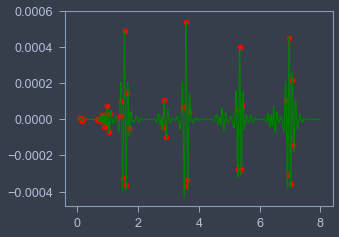

In [212]:
qrs = processing.xqrs_detect(sig=sigmig, fs=50)
plt.plot(time3,sigmig,color="green")
plt.scatter(time3[qrs],sigmig[qrs],color="Red")
len(qrs)/3

In [213]:
def Tompkins(ss,tt):
    sig = np.gradient(ss[0:2400],edge_order=1)
    signal = np.power(sig,2)
    sigmig,time3 = signal_preprocessor(signal,tt,30,30)
    sigmig = np.array(sigmig)
    qrs = processing.xqrs_detect(sig=sigmig, fs=41)
    
    return len(qrs)/3

In [214]:
Tompkins(sm[0],tm[0])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


20.0

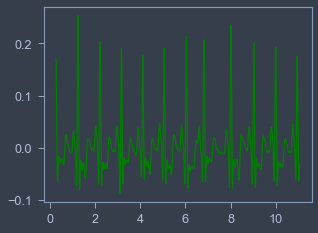

In [215]:
plt.plot(tm[0],sm[0],color="green")

## Tompkins Tests:

#### With VF-VT :

In [216]:
%%capture
counter = 0
for i in lismis1:
    if Tompkins(sm[i],tm[i]) >=32 or Tompkins(sm[i],tm[i]) <= 2:
        counter +=1

In [217]:
counter

39

In [218]:
counter/len(lismis1)

0.20634920634920634

In [225]:
%%capture
counter = 0
for i in lismis2:
    if Tompkins(sm[i],tm[i]) >=32 or Tompkins(sm[i],tm[i]) <= 2:
        counter +=1

In [226]:
counter

57

In [227]:
counter/len(lismis2)

0.5876288659793815

#### Without VF-VT :

In [222]:
%%capture
counter = 0
for i in osmosis:
    if Tompkins(sm[i],tm[i]) <=32 or Tompkins(sm[i],tm[i]) >= 2:
        counter +=1

In [223]:
counter

13952

In [224]:
counter/len(osmosis)

1.0

## Tompkins Extraction:

In [199]:
def Tompkins_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(Tompkins(ss[i],tt[i]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Tompkins"]
    return v

In [200]:
%%capture
Tompkins_DF = Tompkins_ext(sm,tm)

In [228]:
#Tompkins_DF

In [229]:
#Tompkins_DF.to_csv("./Parameter_Data/Tompkins.csv",sep=',')

# Parameter 12: Mean Absolute Value Algorithm

In [233]:
def mav(signal,I1,I2):
    s = 0
    sig = signal/np.amax(np.absolute(signal))
    for i in sig[I1:I2]:
        s+=np.absolute(i)
    return s/len(signal)

In [234]:
mav(ss[2][0][0:2400],0,300)

0.02644043557461253

In [235]:
np.arange(0,int(len(ss[2][0][0:2400])/300)-1,1)

array([0, 1, 2, 3, 4, 5, 6])

In [236]:
def mav_avg(signal,length):
    L = (length-1)
    ran = np.arange(0,int(len(signal)/300)-2,1)
    I1 = 0
    I2= 600
    mavi = []
    for i in ran:
        mavi.append(7*mav(signal,I1,I2))
        I1+=300
        I2+=300
    avg_mav = np.mean(mavi)
    return avg_mav

In [237]:
mav_avg(ss[100][22][0:2400],2)

0.28161079226184715

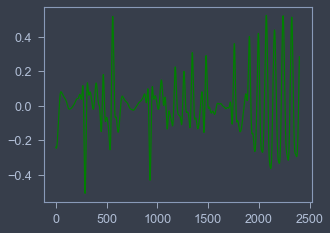

In [238]:
plt.plot(ss[100][22][0:2400],color="green")

## MAV Tests:

#### With VF-VT :

In [239]:
counter = 0
for i in lismis1:
    if mav_avg(sm[i],2) >= 0.27:
        counter+=1
counter

58

In [240]:
counter/len(lismis1)

0.30687830687830686

In [241]:
counter = 0
for i in lismis2:
    if mav_avg(sm[i],2) >= 0.27:
        counter+=1
counter

65

In [242]:
counter/len(lismis2)

0.6701030927835051

#### Without VF-VT : 

In [243]:
counter = 0
for i in osmosis:
    if mav_avg(sm[i],2) <= 0.27:
        counter+=1
counter

9796

In [244]:
counter/len(osmosis)

0.7021215596330275

## MAV Extraction:

In [209]:
def MAV_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(mav_avg(ss[i],2))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["MAV"]
    return v

In [210]:
MAV_DF = MAV_ext(sm)

In [ ]:
#MAV_DF

In [ ]:
#MAV_DF.to_csv("./Parameter_Data/MAV.csv",sep=',')

Note that the threshold for VF-VT is 0.27

## Setting up the Dataframe:

In [26]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

In [5]:
TCI = pd.read_csv("./Parameter_Data/TCI.csv",sep=",")
ACF = pd.read_csv("./Parameter_Data/ACF.csv",sep=",")
VFF = pd.read_csv("./Parameter_Data/VFF.csv",sep=",")
SPEC = pd.read_csv("./Parameter_Data/SPEC.csv",sep=",")
COMP = pd.read_csv("./Parameter_Data/Complexity.csv",sep=",")
STD_EXP = pd.read_csv("./Parameter_Data/Standard_exp.csv",sep=",")
MEA = pd.read_csv("./Parameter_Data/MEA.csv",sep=",")
SCA = pd.read_csv("./Parameter_Data/SCA.csv",sep=",")
WAVE_1 = pd.read_csv("./Parameter_Data/Wave1.csv",sep=",")
WAVE_2 = pd.read_csv("./Parameter_Data/Wave2.csv",sep=",")
Li = pd.read_csv("./Parameter_Data/Li.csv",sep=",")
Tompkins = pd.read_csv("./Parameter_Data/Tompkins.csv",sep=",")
MAV = pd.read_csv("./Parameter_Data/MAV.csv",sep=",")
VFVT_Labels = pd.read_csv("./Parameter_Data/Labels.csv",sep=",")
VF = pd.read_csv("./Parameter_Data/VF.csv",sep=",")
VT = pd.read_csv("./Parameter_Data/VT.csv",sep=",")

In [6]:
del TCI['Unnamed: 0']
del ACF['Unnamed: 0']
del VFF['Unnamed: 0']
del SPEC['Unnamed: 0']
del COMP['Unnamed: 0']
del STD_EXP['Unnamed: 0']
del MEA['Unnamed: 0']
del SCA['Unnamed: 0']
del WAVE_1['Unnamed: 0']
del WAVE_2['Unnamed: 0']
del Li['Unnamed: 0']
del Tompkins['Unnamed: 0']
del MAV['Unnamed: 0']
del VFVT_Labels['Unnamed: 0']
del VF['Unnamed: 0']
del VT['Unnamed: 0']

In [7]:
Allofem = [TCI,ACF,VFF,SPEC,COMP,STD_EXP,MEA,SCA,WAVE_1,WAVE_2,Li,Tompkins,MAV]
Labs = [VT,VF]
Params = pd.concat(Allofem,axis=1)
Labels = pd.concat(Labs,axis=1)

## SVM:

In [139]:
model = svm.SVC()
model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [140]:
X = np.array(Params)
Y = np.array(VFVT_Labels)

In [141]:
Y = Y.flatten()

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [143]:
model.fit(X_train,Y_train)

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [144]:
Y_pred = model.predict(X_test)

In [145]:
accuracy_score(Y_test,Y_pred)

0.980688202247191

## With two classes, VF and VT:

In [8]:
X = np.array(Params)
Y = np.array(Labels)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [11]:
model = OneVsRestClassifier(svm.SVC(kernel='rbf'))
model

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='rbf', max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

In [12]:
model.fit(X_train,Y_train)

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='rbf', max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

In [13]:
Y_pred = model.predict(X_test)

In [14]:
accuracy_score(Y_test,Y_pred)

0.980688202247191

In [30]:
1- mean_squared_error(Y_test,Y_pred)

0.9901685393258427

## LS-SVM: